# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.71KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

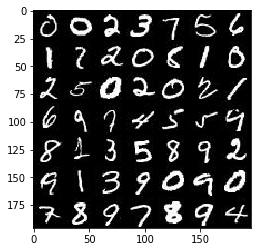

In [1]:
data_dir = './data'
import helper
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

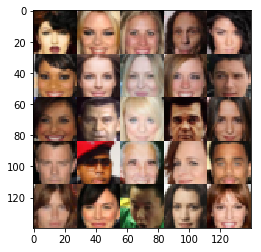

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [4]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learn_rate = tf.placeholder(tf.float32, name='learn_rate')

    return inputs_real, inputs_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [5]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x(3/1)
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [6]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 14x14x64
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [7]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [8]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [10]:
class GAN:
    def __init__(self, img_shape, z_dim, learning_rate, beta1):
        tf.reset_default_graph()
        self.input_real, self.input_z, lr = model_inputs(img_shape[0], img_shape[1], img_shape[2], z_dim)
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, img_shape[2])
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    net = GAN(data_shape[1:4], z_dim, learning_rate, beta1)
    print_every = 100
    steps = 0
    n_images = 25
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                #fix the scale in the source images
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images})

                if steps % 10 == 0:
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % print_every == 0:
                    show_generator_output(sess, n_images, net.input_z, data_shape[3], data_image_mode)
            print('End Epoch '+str(epoch_i+1))
        show_generator_output(sess, n_images, net.input_z, data_shape[3], data_image_mode)
    print('Ending run')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7955... Generator Loss: 1.0430
Epoch 1/2... Discriminator Loss: 0.9824... Generator Loss: 1.9324
Epoch 1/2... Discriminator Loss: 1.8042... Generator Loss: 0.2755
Epoch 1/2... Discriminator Loss: 1.4821... Generator Loss: 0.3777
Epoch 1/2... Discriminator Loss: 1.1720... Generator Loss: 0.6768
Epoch 1/2... Discriminator Loss: 1.2799... Generator Loss: 0.6574
Epoch 1/2... Discriminator Loss: 1.0919... Generator Loss: 0.6273
Epoch 1/2... Discriminator Loss: 1.3269... Generator Loss: 0.4743
Epoch 1/2... Discriminator Loss: 1.0477... Generator Loss: 0.9861
Epoch 1/2... Discriminator Loss: 1.2530... Generator Loss: 0.8497


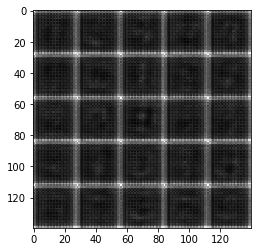

Epoch 1/2... Discriminator Loss: 1.2579... Generator Loss: 0.5324
Epoch 1/2... Discriminator Loss: 1.1094... Generator Loss: 0.6804
Epoch 1/2... Discriminator Loss: 0.9792... Generator Loss: 1.2953
Epoch 1/2... Discriminator Loss: 1.0539... Generator Loss: 1.7241
Epoch 1/2... Discriminator Loss: 0.9604... Generator Loss: 1.4415
Epoch 1/2... Discriminator Loss: 0.8471... Generator Loss: 1.3529
Epoch 1/2... Discriminator Loss: 1.0044... Generator Loss: 0.6556
Epoch 1/2... Discriminator Loss: 0.9939... Generator Loss: 0.6446
Epoch 1/2... Discriminator Loss: 0.7615... Generator Loss: 0.9747
Epoch 1/2... Discriminator Loss: 1.1135... Generator Loss: 0.5135


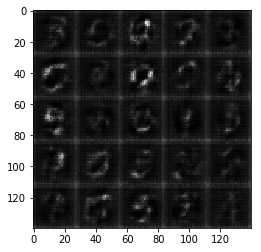

Epoch 1/2... Discriminator Loss: 1.2109... Generator Loss: 0.4172
Epoch 1/2... Discriminator Loss: 1.4364... Generator Loss: 2.6816
Epoch 1/2... Discriminator Loss: 0.7478... Generator Loss: 1.4355
Epoch 1/2... Discriminator Loss: 0.7819... Generator Loss: 1.1710
Epoch 1/2... Discriminator Loss: 0.7697... Generator Loss: 1.0860
Epoch 1/2... Discriminator Loss: 1.5691... Generator Loss: 0.2712
Epoch 1/2... Discriminator Loss: 1.0305... Generator Loss: 0.5743
Epoch 1/2... Discriminator Loss: 0.7835... Generator Loss: 1.4268
Epoch 1/2... Discriminator Loss: 1.0186... Generator Loss: 0.6017
Epoch 1/2... Discriminator Loss: 0.9709... Generator Loss: 0.7747


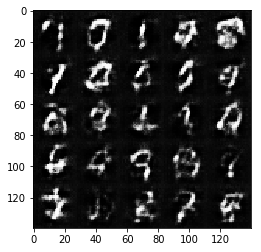

Epoch 1/2... Discriminator Loss: 0.8012... Generator Loss: 1.2535
Epoch 1/2... Discriminator Loss: 1.0222... Generator Loss: 0.6355
Epoch 1/2... Discriminator Loss: 1.4111... Generator Loss: 0.3367
Epoch 1/2... Discriminator Loss: 1.0235... Generator Loss: 0.6230
Epoch 1/2... Discriminator Loss: 0.9709... Generator Loss: 1.2640
Epoch 1/2... Discriminator Loss: 1.1644... Generator Loss: 0.5052
Epoch 1/2... Discriminator Loss: 0.8927... Generator Loss: 1.3392
Epoch 1/2... Discriminator Loss: 0.9391... Generator Loss: 0.8570
Epoch 1/2... Discriminator Loss: 1.0853... Generator Loss: 0.5577
Epoch 1/2... Discriminator Loss: 1.3224... Generator Loss: 0.4018


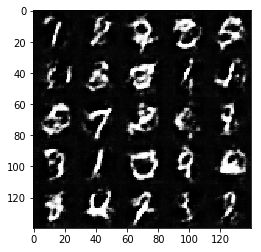

Epoch 1/2... Discriminator Loss: 1.0025... Generator Loss: 0.6003
Epoch 1/2... Discriminator Loss: 1.0824... Generator Loss: 1.7753
Epoch 1/2... Discriminator Loss: 1.0801... Generator Loss: 0.5887
Epoch 1/2... Discriminator Loss: 1.1522... Generator Loss: 1.5168
Epoch 1/2... Discriminator Loss: 0.9908... Generator Loss: 0.7279
Epoch 1/2... Discriminator Loss: 1.1381... Generator Loss: 1.6510
Epoch 1/2... Discriminator Loss: 1.0150... Generator Loss: 1.0718
Epoch 1/2... Discriminator Loss: 0.9628... Generator Loss: 0.9973
Epoch 1/2... Discriminator Loss: 1.4050... Generator Loss: 0.3587
Epoch 1/2... Discriminator Loss: 1.0982... Generator Loss: 1.5200


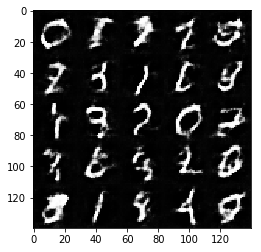

Epoch 1/2... Discriminator Loss: 1.0023... Generator Loss: 0.8262
Epoch 1/2... Discriminator Loss: 1.5298... Generator Loss: 0.3232
Epoch 1/2... Discriminator Loss: 1.0080... Generator Loss: 1.1583
Epoch 1/2... Discriminator Loss: 1.4428... Generator Loss: 2.0050
Epoch 1/2... Discriminator Loss: 1.1428... Generator Loss: 1.4908
Epoch 1/2... Discriminator Loss: 1.1004... Generator Loss: 1.1406
Epoch 1/2... Discriminator Loss: 1.0411... Generator Loss: 0.6551
Epoch 1/2... Discriminator Loss: 1.0716... Generator Loss: 1.1791
Epoch 1/2... Discriminator Loss: 1.2426... Generator Loss: 0.4849
Epoch 1/2... Discriminator Loss: 0.8984... Generator Loss: 1.1751


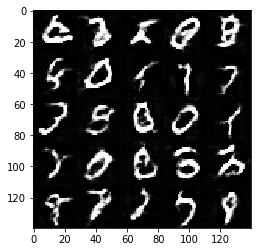

End Epoch 1
Epoch 2/2... Discriminator Loss: 1.2969... Generator Loss: 0.4187
Epoch 2/2... Discriminator Loss: 1.1363... Generator Loss: 0.5892
Epoch 2/2... Discriminator Loss: 1.1129... Generator Loss: 0.6117
Epoch 2/2... Discriminator Loss: 1.1721... Generator Loss: 1.5388
Epoch 2/2... Discriminator Loss: 1.0236... Generator Loss: 0.9822
Epoch 2/2... Discriminator Loss: 1.0149... Generator Loss: 0.6569
Epoch 2/2... Discriminator Loss: 1.8835... Generator Loss: 0.2102
Epoch 2/2... Discriminator Loss: 1.0295... Generator Loss: 0.8778
Epoch 2/2... Discriminator Loss: 1.0412... Generator Loss: 0.7737
Epoch 2/2... Discriminator Loss: 1.0403... Generator Loss: 1.1004


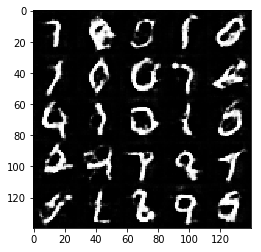

Epoch 2/2... Discriminator Loss: 1.0490... Generator Loss: 0.6692
Epoch 2/2... Discriminator Loss: 1.1515... Generator Loss: 1.5471
Epoch 2/2... Discriminator Loss: 1.1499... Generator Loss: 0.6712
Epoch 2/2... Discriminator Loss: 1.6927... Generator Loss: 0.2632
Epoch 2/2... Discriminator Loss: 0.9328... Generator Loss: 0.8538
Epoch 2/2... Discriminator Loss: 1.2870... Generator Loss: 0.4304
Epoch 2/2... Discriminator Loss: 1.0210... Generator Loss: 1.1888
Epoch 2/2... Discriminator Loss: 1.2717... Generator Loss: 1.9271
Epoch 2/2... Discriminator Loss: 1.1369... Generator Loss: 0.5419
Epoch 2/2... Discriminator Loss: 1.1170... Generator Loss: 0.6405


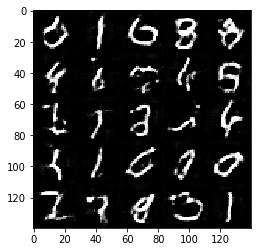

Epoch 2/2... Discriminator Loss: 0.9545... Generator Loss: 0.8292
Epoch 2/2... Discriminator Loss: 1.1932... Generator Loss: 1.0129
Epoch 2/2... Discriminator Loss: 1.0013... Generator Loss: 1.2711
Epoch 2/2... Discriminator Loss: 1.0295... Generator Loss: 0.7576
Epoch 2/2... Discriminator Loss: 1.0850... Generator Loss: 0.7605
Epoch 2/2... Discriminator Loss: 1.0272... Generator Loss: 0.9107
Epoch 2/2... Discriminator Loss: 1.0015... Generator Loss: 0.9696
Epoch 2/2... Discriminator Loss: 1.3644... Generator Loss: 1.7236
Epoch 2/2... Discriminator Loss: 1.2349... Generator Loss: 0.5227
Epoch 2/2... Discriminator Loss: 1.0167... Generator Loss: 0.6529


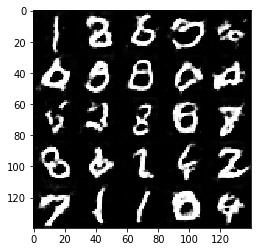

Epoch 2/2... Discriminator Loss: 1.1092... Generator Loss: 0.6563
Epoch 2/2... Discriminator Loss: 1.5081... Generator Loss: 2.4333
Epoch 2/2... Discriminator Loss: 0.9784... Generator Loss: 1.1417
Epoch 2/2... Discriminator Loss: 0.9160... Generator Loss: 0.9077
Epoch 2/2... Discriminator Loss: 1.0247... Generator Loss: 0.6696
Epoch 2/2... Discriminator Loss: 0.8546... Generator Loss: 0.9192
Epoch 2/2... Discriminator Loss: 0.9873... Generator Loss: 0.9303
Epoch 2/2... Discriminator Loss: 0.9350... Generator Loss: 0.8714
Epoch 2/2... Discriminator Loss: 1.0457... Generator Loss: 0.9071
Epoch 2/2... Discriminator Loss: 1.0434... Generator Loss: 0.9547


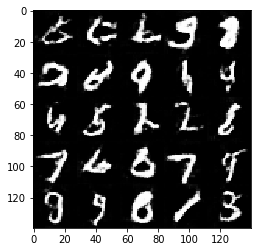

Epoch 2/2... Discriminator Loss: 0.9712... Generator Loss: 0.8808
Epoch 2/2... Discriminator Loss: 2.8087... Generator Loss: 0.0836
Epoch 2/2... Discriminator Loss: 1.1023... Generator Loss: 0.7077
Epoch 2/2... Discriminator Loss: 1.0575... Generator Loss: 0.7260
Epoch 2/2... Discriminator Loss: 0.9442... Generator Loss: 0.8825
Epoch 2/2... Discriminator Loss: 1.1036... Generator Loss: 0.6439
Epoch 2/2... Discriminator Loss: 1.1812... Generator Loss: 1.0800
Epoch 2/2... Discriminator Loss: 0.9893... Generator Loss: 0.8160
Epoch 2/2... Discriminator Loss: 0.9823... Generator Loss: 0.9761
Epoch 2/2... Discriminator Loss: 0.9771... Generator Loss: 0.7900


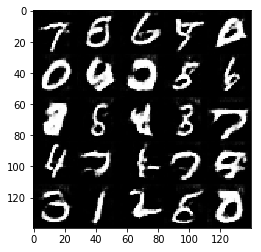

Epoch 2/2... Discriminator Loss: 0.9233... Generator Loss: 1.3892
Epoch 2/2... Discriminator Loss: 0.9266... Generator Loss: 0.7771
Epoch 2/2... Discriminator Loss: 0.8953... Generator Loss: 1.1066
Epoch 2/2... Discriminator Loss: 0.9636... Generator Loss: 0.8105
Epoch 2/2... Discriminator Loss: 1.0535... Generator Loss: 1.0712
Epoch 2/2... Discriminator Loss: 0.9410... Generator Loss: 0.9897
Epoch 2/2... Discriminator Loss: 0.8293... Generator Loss: 1.1428
Epoch 2/2... Discriminator Loss: 1.1388... Generator Loss: 0.5656
Epoch 2/2... Discriminator Loss: 1.3922... Generator Loss: 0.3634
Epoch 2/2... Discriminator Loss: 0.7807... Generator Loss: 1.3300


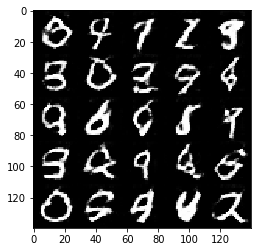

End Epoch 2


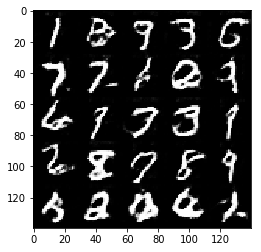

Ending run


IndexError: list index out of range

In [16]:
batch_size = 100
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.5561
Epoch 1/1... Discriminator Loss: 2.0145... Generator Loss: 0.2618
Epoch 1/1... Discriminator Loss: 2.2264... Generator Loss: 0.4053
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 1.5747
Epoch 1/1... Discriminator Loss: 1.9525... Generator Loss: 0.3216
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 1.2625
Epoch 1/1... Discriminator Loss: 1.5549... Generator Loss: 1.0067
Epoch 1/1... Discriminator Loss: 1.5131... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 0.8520


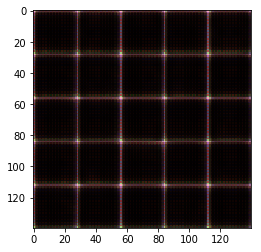

Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 1.0394
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 0.9009
Epoch 1/1... Discriminator Loss: 1.5311... Generator Loss: 0.5166
Epoch 1/1... Discriminator Loss: 1.6800... Generator Loss: 0.4077
Epoch 1/1... Discriminator Loss: 1.6858... Generator Loss: 0.4150
Epoch 1/1... Discriminator Loss: 1.8242... Generator Loss: 0.3663
Epoch 1/1... Discriminator Loss: 1.6349... Generator Loss: 0.4209
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.5168
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 1.3798


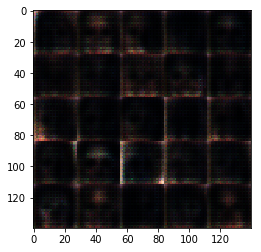

Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 0.8748
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.6342
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.4402
Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 0.9544
Epoch 1/1... Discriminator Loss: 1.7408... Generator Loss: 0.5969
Epoch 1/1... Discriminator Loss: 1.6381... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 1.1806
Epoch 1/1... Discriminator Loss: 1.5136... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.9425


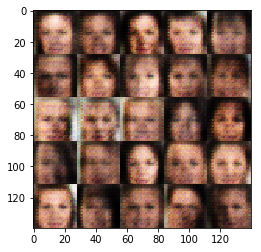

Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.5169... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.9914
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.5685... Generator Loss: 0.5917


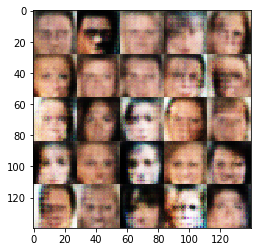

Epoch 1/1... Discriminator Loss: 1.5203... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.9697
Epoch 1/1... Discriminator Loss: 1.4598... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.5614
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.4777... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.6379... Generator Loss: 1.6050
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.8282


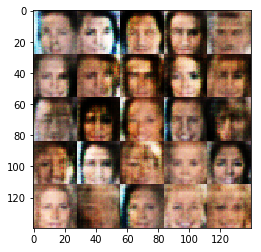

Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.9847
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.5178... Generator Loss: 1.1850
Epoch 1/1... Discriminator Loss: 1.4553... Generator Loss: 1.1249
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 1.5047
Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 0.6042
Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.9739


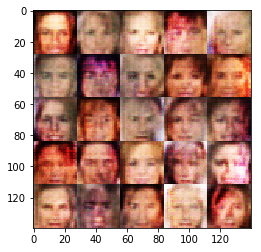

Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.9238... Generator Loss: 0.2616
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.5074... Generator Loss: 1.0476
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 1.6008
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 0.8507... Generator Loss: 1.3675
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.9532


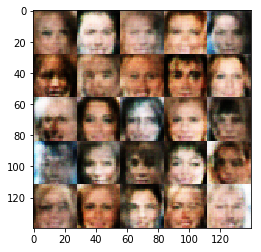

Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.9372
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.5063... Generator Loss: 0.4308
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.9590
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.4362
Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 1.1870
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.8096


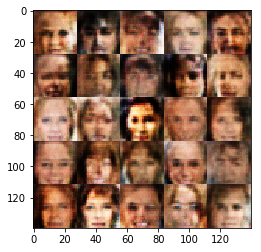

Epoch 1/1... Discriminator Loss: 1.1226... Generator Loss: 0.9463
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 0.8901
Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 1.5914
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.9840
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 0.8658
Epoch 1/1... Discriminator Loss: 1.4969... Generator Loss: 0.9295
Epoch 1/1... Discriminator Loss: 1.5418... Generator Loss: 0.3841
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 1.1337
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 0.8224


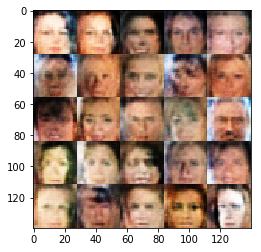

Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 1.0428
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 1.0246
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 1.1651
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.4179
Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.0904... Generator Loss: 1.2346
Epoch 1/1... Discriminator Loss: 0.8247... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 1.5833... Generator Loss: 2.4182
Epoch 1/1... Discriminator Loss: 1.1205... Generator Loss: 1.0320


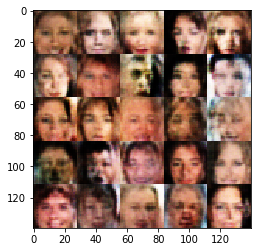

Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 1.0867
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 1.3258
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 0.9487
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.5487
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 1.0109
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.5224


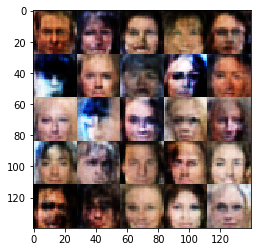

Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 0.9775
Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 0.9870
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.4918
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 1.0921
Epoch 1/1... Discriminator Loss: 1.5322... Generator Loss: 0.4445
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.5978
Epoch 1/1... Discriminator Loss: 1.0697... Generator Loss: 0.9321
Epoch 1/1... Discriminator Loss: 0.7614... Generator Loss: 1.3223


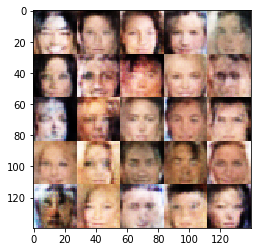

Epoch 1/1... Discriminator Loss: 1.0047... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.1459... Generator Loss: 1.0868
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 0.8802
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 1.1902
Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.5483... Generator Loss: 0.4173
Epoch 1/1... Discriminator Loss: 1.6030... Generator Loss: 0.3666
Epoch 1/1... Discriminator Loss: 1.7993... Generator Loss: 0.2594
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 0.5774


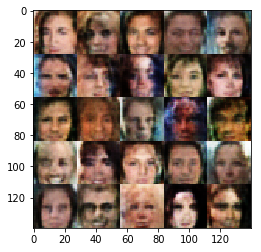

Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 1.1130
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.5863
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.5512
Epoch 1/1... Discriminator Loss: 1.7096... Generator Loss: 0.2747
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 0.7211... Generator Loss: 1.5961
Epoch 1/1... Discriminator Loss: 1.7643... Generator Loss: 0.2603
Epoch 1/1... Discriminator Loss: 0.7859... Generator Loss: 2.1066


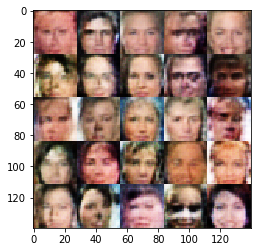

Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.5799
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 1.0449
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 1.2127
Epoch 1/1... Discriminator Loss: 2.0167... Generator Loss: 0.1778
Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 0.9879... Generator Loss: 1.3714
Epoch 1/1... Discriminator Loss: 0.7170... Generator Loss: 2.1191
Epoch 1/1... Discriminator Loss: 0.6547... Generator Loss: 1.0893
Epoch 1/1... Discriminator Loss: 1.1458... Generator Loss: 1.8247
Epoch 1/1... Discriminator Loss: 1.6670... Generator Loss: 0.2581


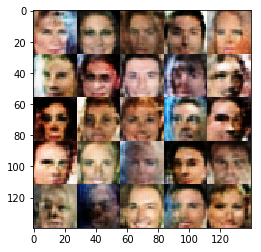

Epoch 1/1... Discriminator Loss: 0.9416... Generator Loss: 1.4638
Epoch 1/1... Discriminator Loss: 0.7428... Generator Loss: 1.0868
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.3825
Epoch 1/1... Discriminator Loss: 1.1009... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 0.8976... Generator Loss: 1.7048
Epoch 1/1... Discriminator Loss: 0.4880... Generator Loss: 2.2577
Epoch 1/1... Discriminator Loss: 0.6824... Generator Loss: 1.1688
Epoch 1/1... Discriminator Loss: 0.5678... Generator Loss: 2.7212
End Epoch 1


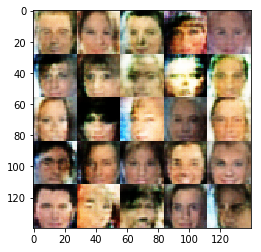

Ending run


IndexError: list index out of range

In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.